In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf,erfc
np.random.seed(123)
tf.set_random_seed(123)
from tensorflow.examples.tutorials.mnist import input_data

from utils import *
from pwa import PWA

In [18]:
def trainer(opts,epoch,nr_samples):
    #model
    model = PWA(opts)
    batch_size = opts['batch_size']
    mnist = input_data.read_data_sets('MNIST_data',one_hot=True)
    fmnist = input_data.read_data_sets('Fashion_MNIST_data',one_hot=True)
    from tqdm import tqdm
    #training loop
    for ep in range(epoch):
        for iter in tqdm(range(nr_samples // batch_size)):
            #obtain a mini-batch
            #tuple:images,labels
            if opts['dataset'] == 'mnist':
                #if opts['dataset'] == 'fmnist':
                #    mnist = fmnist

                batch = mnist.train.next_batch(batch_size)[0]
                if opts['binarize']:
                    batch = np.random.binomial(1,batch)
                loss, mloss, rloss, kloss = model.run_single_step(batch,training=False)

            elif opts['dataset'] == 'celeba':
                loss, mloss, rloss, kloss = model.run_single_step(np.zeros(shape=(batch_size,784),dtype=float),training=False)

            #train: execute forward and backward pass
        print('[Epoch {}] Loss: {}, {}, {}'.format(ep,rloss,mloss,kloss))
    print('Done!')
    return model

## Training

In [ ]:
tf.reset_default_graph()
np.random.seed(13)
tf.set_random_seed(13)
opts = {}
opts['dataset'] = 'mnist' # 'fmnist', 'celeba'
opts['lr_adam'] = 1e-3
opts['lr_rsgd'] = 1e-3
opts['batch_size'] = 64
opts['beta_mmd'] = 1e3
opts['beta_kld'] = 10.0
opts['lambda_mmd'] = 1.0
opts['varregnorm'] = 2 # L1 or L2
opts['dim_z'] = 5
opts['hyp_c'] = 1.0
opts['mmd_q'] = 1
opts['use_expmap'] = False
opts['nw_size'] = 'large'
opts['binarize'] = True
opts['init_std'] = 0.01
opts['init_bias'] = 0.0
opts['conv_filters_dim'] = 5
opts['num_filters'] = 1024
opts['num_layers'] = 4

print(opts)
#nr_samples = mnist.train.num_examples
model = trainer(opts, epoch=20, nr_samples=60000) 

## Reconstruction

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


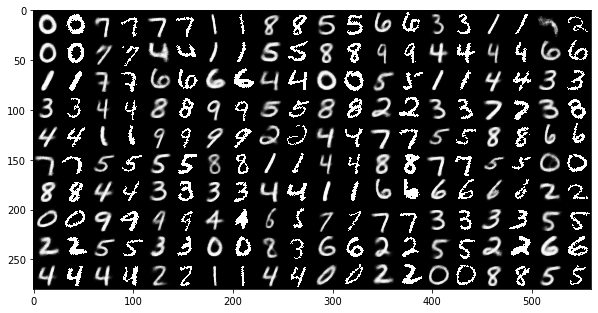

In [9]:
#reconstruction: left recon, right ground truth
#z = np.random.normal(size=[model.batch_size,model.dim_z])
mnist = input_data.read_data_sets('MNIST_data',one_hot=True)
batch = mnist.test.next_batch(100)
batch = batch[0]
if opts['binarize']:
    batch = np.random.binomial(1,batch)
x_reconstructed, z = model.reconstruction(batch)
#x_generated = model.generate(z)
n = 10
h = 28
w = 28
I_reconstructed = np.empty((h*n,2*w*n))

for i in range(n):
    for j in range(n):
        x = np.concatenate((x_reconstructed[i*n+j,:].reshape(h,w),batch[i*n+j,:].reshape(h,w)),axis=1)
        I_reconstructed[i*h:(i+1)*h,j*2*w:(j+1)*2*w] = x
plt.figure(figsize = (10,20))
plt.imshow(I_reconstructed,cmap='gray')
#plt.savefig('mnist_recon.png',dpi=300)

## Generation

(64, 5)


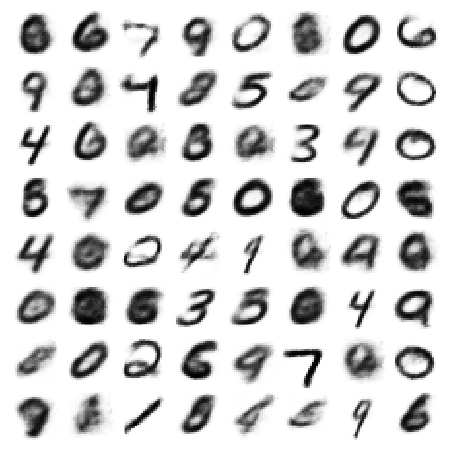

In [10]:
z = np_project_hyp_vec(np_sample_gauss_pd(shape=[model.batch_size, model.dim_z],oversample=20,radius=1.0,sigma=1.0),1.0)
print(z.shape)

x_generated = model.generate(z)
h = 28
w = 28
# 10x10 grid
n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(28, 28)

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(I_generated, cmap='gray_r')
plt.savefig('mnist_5_h_100ep.png')

## Train the model with 2d latent space

In [ ]:
tf.reset_default_graph()
opts_2d = {}
opts_2d['dataset'] = 'mnist'
opts_2d['lr_adam'] = 1e-3
opts_2d['lr_rsgd'] = 1e-3
opts_2d['batch_size'] = 100 
opts_2d['beta_mmd'] = 1e2
opts_2d['beta_kld'] = 10.0
opts_2d['lambda_mmd'] = 1.0
opts_2d['mmd_kernel'] = 'laplacian'
opts_2d['varregnorm'] = 2 # L1 or L2
opts_2d['dim_z'] = 2
opts_2d['hyp_c'] = 1.0
opts_2d['mmd_q'] = 1
opts_2d['nw_size'] = 'large'
opts_2d['use_expmap'] = False
opts_2d['binarize'] = True

model_2d = trainer(opts_2d,epoch=5, nr_samples=60000)

## Scatter plot

In [ ]:
# Test the trained model: transformation
batch = mnist.test.next_batch(3000)
z = model_2d.transformer(batch[0])

#z_prior = np_sample_gauss_hp(shape=[model_2d.batch_size, model_2d.dim_z],oversample=20,radius=3.0,sigma=1.0)
#z_prior = np_exp_map(1.0*np.random.randn(model_2d.batch_size, model_2d.dim_z).astype(np.float32),c=1.0)
z_prior = np_sample_gauss_pd(shape=[model_2d.batch_size, model_2d.dim_z],oversample=20,radius=0.85,sigma=1.0)

plt.figure(figsize=(10, 8)) 
plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1))
plt.scatter(z_prior[:,0],z_prior[:,1],c='r')
#plt.colorbar()
plt.axis('equal')
plt.grid()
plt.show()

## Generate 2d grid

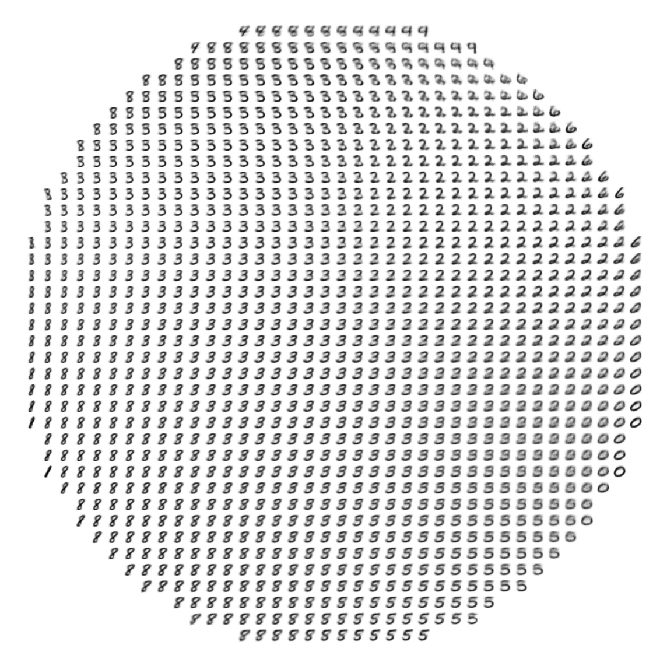

In [28]:
n = 40
x = np.linspace(-1.0, 1.0, n)
y = np.linspace(-1.0, 1.0, n)

#r = np.logspace(0, 1, n)
#y = np.linspace(0,2*pi,n)
h = 28
w = 28

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d.batch_size)
        x_hat = model_2d.generate(z)
        I_latent[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = x_hat[20].reshape(28, 28)
        
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(I_latent, cmap="gray_r")
plt.savefig("mnist_disk_5ep.png")
plt.show()